In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

In [6]:
# Load AWMT data from data directory
data_dir = os.path.join(os.getcwd(), 'data')
awmt_file = os.path.join(data_dir, 'AWMT_flow_experiment_1707494630.csv')
df_awmt = pd.read_csv(awmt_file)

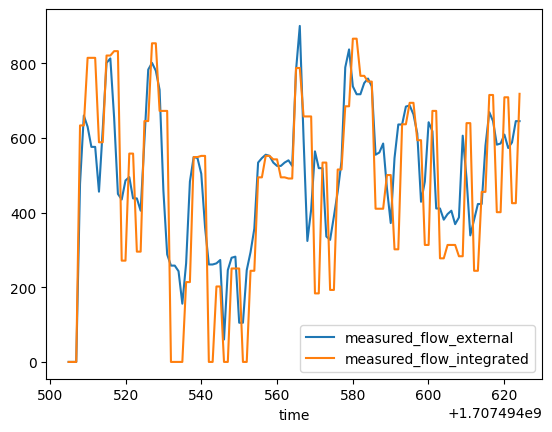

RMS error: 158.88 L/hour


In [9]:
# Plot internal and external flow vs time
fig, ax = plt.subplots()
df_awmt.plot(x='time', y='measured_flow_external', ax=ax)
df_awmt.plot(x='time', y='measured_flow_integrated', ax=ax)
plt.show()

# RMS error
rms_error = ((df_awmt['measured_flow_integrated'] - df_awmt['measured_flow_external'])**2).mean()**0.5
print(f'RMS error: {rms_error:.2f} L/hour')

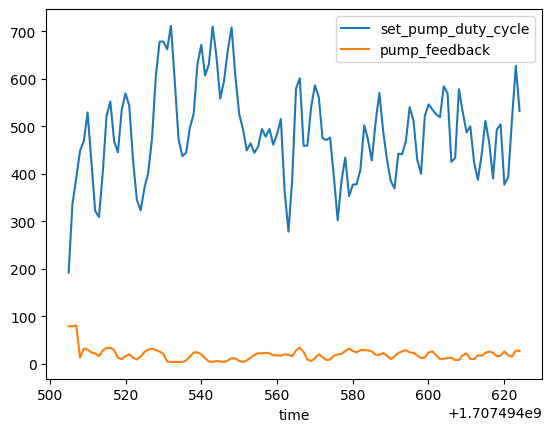

In [11]:
fig, ax = plt.subplots()
df_awmt.plot(x='time', y='set_pump_duty_cycle', ax=ax)
df_awmt.plot(x='time', y='pump_feedback', ax=ax)
plt.show()


Pump feedback = -0.08 * set pump duty cycle + 55.04
Standard deviation of the residuals: 1.91


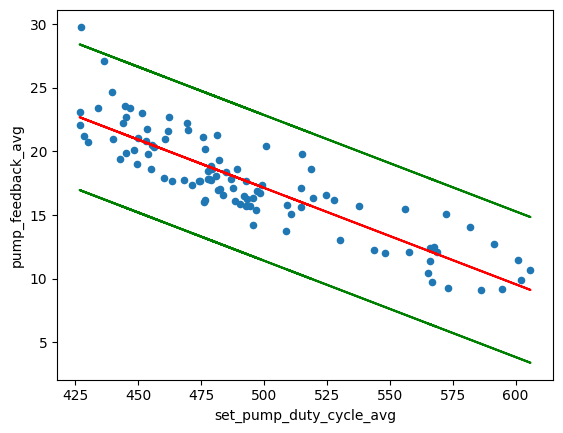

In [23]:
window_size = 20  # 10-second window size

# Calculate the moving averages
df_awmt['set_pump_duty_cycle_avg'] = df_awmt['set_pump_duty_cycle'].rolling(window_size).mean()
df_awmt['pump_feedback_avg'] = df_awmt['pump_feedback'].rolling(window_size).mean()

# Drop missing values
df_awmt_trimmed = df_awmt.dropna()

# Estimate a liner model of the pump feedback with the set pump duty cycle as input
X = df_awmt_trimmed['set_pump_duty_cycle_avg'].values.reshape(-1, 1)
y = df_awmt_trimmed['pump_feedback_avg'].values
model = LinearRegression().fit(X, y)
a = model.coef_[0]
b = model.intercept_
print(f'Pump feedback = {a:.2f} * set pump duty cycle + {b:.2f}')
# Print standard deviation of the residuals
y_pred = model.predict(X)
residuals = y - y_pred
std_residuals = np.std(residuals)
print(f'Standard deviation of the residuals: {std_residuals:.2f}')

# Plot the moving averages
fig, ax = plt.subplots()
df_awmt_trimmed.plot.scatter(x='set_pump_duty_cycle_avg', y='pump_feedback_avg', ax=ax)
ax.plot(df_awmt_trimmed['set_pump_duty_cycle_avg'], y_pred, color='red')
ax.plot(df_awmt_trimmed['set_pump_duty_cycle_avg'], y_pred + 3*std_residuals, color='green')
ax.plot(df_awmt_trimmed['set_pump_duty_cycle_avg'], y_pred - 3*std_residuals, color='green')
plt.show()


C:\Users\dhruv\AppData\Local\Temp\ipykernel_35944\2752377012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_awmt_trimmed['pump_feedback_pred'] = model.predict(df_awmt_trimmed['set_pump_duty_cycle_avg'].values.reshape(-1, 1))


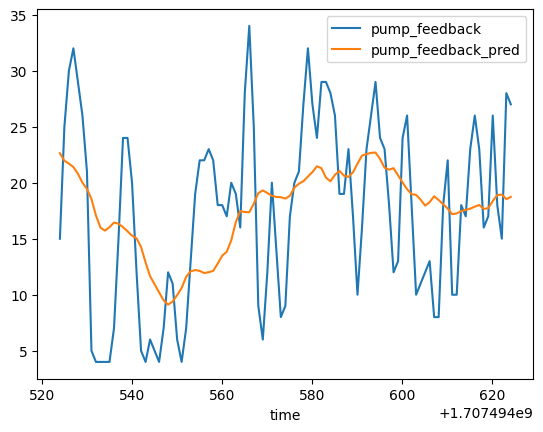

In [27]:
# Plot measured pump feedback and predicted pump feedback vs time
df_awmt_trimmed['pump_feedback_pred'] = model.predict(df_awmt_trimmed['set_pump_duty_cycle_avg'].values.reshape(-1, 1))
fig, ax = plt.subplots()
df_awmt_trimmed.plot(x='time', y='pump_feedback', ax=ax)
df_awmt_trimmed.plot(x='time', y='pump_feedback_pred', ax=ax)
plt.show()


Estimated coefficients:
[[ 0.01141089]
 [-0.0455945 ]
 [ 0.03961401]
 [ 0.00862287]
 [ 0.01940209]
 [-0.09106567]
 [ 0.64082351]]
RMS error: 5.29


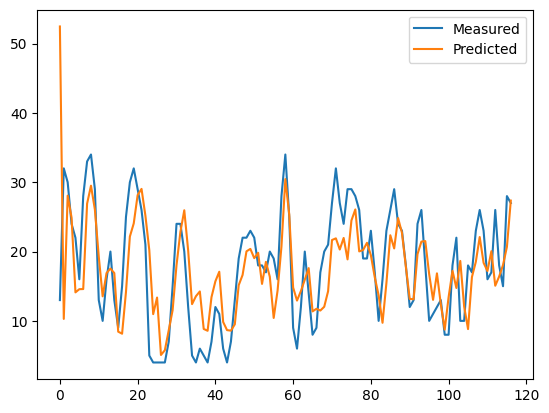

In [41]:
# Model pump feedback as a 3rd order ARX model of the set pump duty cycle
# y(t) = a0*u(t) + a1*u(t-1) + a2*u(t-2) + a3*u(t-3) + b1*y(t-1) + b2*y(t-2) + b3*y(t-3) + e(t)
# where u is the set pump duty cycle and y is the pump feedback
# Estimate the coefficients using least squares
n = len(df_awmt)
U = np.zeros((n, 7))
Y = np.zeros((n, 1))
for i in range(3, n):
    U[i, 0:4] = df_awmt['set_pump_duty_cycle'].values[i-3:i+1]
    U[i, 4:7] = df_awmt['pump_feedback'].values[i-3:i]
    Y[i] = df_awmt['pump_feedback'].values[i]
# Remove rows with all zeros
mask = np.any(U, axis=1)
U = U[mask, :]
Y = Y[mask, :]
# Estimate the coefficients
theta = np.linalg.lstsq(U, Y, rcond=None)[0]
print('Estimated coefficients:')
print(theta)

# Plot the measured and predicted pump feedback
Y_pred = np.dot(U, theta)

# Prirnt RMS error
rms_error = np.sqrt(np.mean((Y[10:] - Y_pred[10:])**2))
print(f'RMS error: {rms_error:.2f}')

fig, ax = plt.subplots()
ax.plot(Y[:, 0], label='Measured')
ax.plot(Y_pred[:, 0], label='Predicted')
ax.legend()
plt.show()


Estimated coefficients: {'a': array([[ 0.89626751],
       [-0.1215619 ],
       [ 0.03430973],
       [-0.01740089],
       [ 0.02768083]]), 'b': array([[[ 0.0031973 ],
        [-0.0115056 ],
        [-0.05911894],
        [ 0.04030955],
        [ 0.01327708]]]), 'c': array([9.95037936])}
RMS error: 11.42


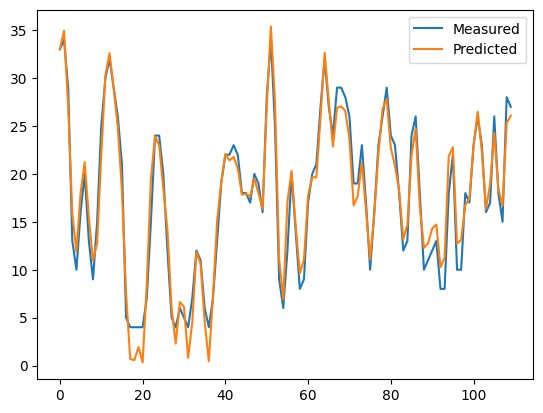

In [43]:
# Use GEKKO to estimate a 2nd order OE model of the pump feedback
from gekko import GEKKO
m = GEKKO(remote
            =False)
na = 5 # output coefficients
nb = 5 # input coefficients
t = df_awmt['idx'].values
u = df_awmt['set_pump_duty_cycle'].values
y = df_awmt['pump_feedback'].values

yp, p, K = m.sysid(t, u, y, na, nb, pred='model', shift='calc')
print(f'Estimated coefficients: {p}')
# Print rms error
rms_error = ((y[10:] - yp[10:])**2).mean()**0.5
print(f'RMS error: {rms_error:.2f}')

# Plot the measured and predicted pump feedback
fig, ax = plt.subplots()
ax.plot(y[10:], label='Measured')
ax.plot(yp[10:], label='Predicted')
ax.legend()
plt.show()
